In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image

In [2]:
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

In [3]:
path = '../data/test/PittsStereo-RGBNIR'
prefix = '230920_001510'
img0 = Image.open(f'{path}/{prefix}_NIRResize.png')
img1 = Image.open(f'{path}/{prefix}_RGBResize.png')
img0  = np.array(img0,  dtype=np.float32)[..., np.newaxis].repeat(3, axis=2)
img1 = np.array(img1, dtype=np.float32)
img_rights = [img1]
img0.shape, img1.shape

((429, 582, 3), (429, 582, 3))

In [4]:
def toTensor(img):
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255)

x_left = toTensor(img0).unsqueeze(0).to('cuda')
x_rights = [toTensor(img_right).unsqueeze(0).to('cuda') for img_right in img_rights]

In [5]:
net = PASSRnet(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

<All keys matched successfully>

In [6]:
# res_w1, res_h1 = 4024, 3036
# res_w2, res_h2 = 4912, 3684
# F = np.array([[3.61267656798871e-09,	3.03286396787507e-07,	-0.00145439021009031],
# [-4.06053956369527e-07,	2.04760848754980e-08,	0.0202623801005043],
# [0.00103349357679728,	-0.00677562855132053,	-23.3433435488500]])

# image_coor = np.meshgrid(np.arange(res_h1), np.arange(res_w1))
# cam_coor = np.stack([image_coor[1].T,
#                      image_coor[0].T,
#                      np.ones_like(image_coor[1].T)], axis=2)
# image_coor2 = np.meshgrid(np.arange(res_h2), np.arange(res_w2))
# cam_coor2 = np.stack([image_coor2[1].T,
#                       image_coor2[0].T,
#                       np.ones_like(image_coor2[1].T)], axis=2)

In [7]:
with torch.no_grad():
    x_left = net.module.init_feature(x_left)
    x_rights = [net.module.init_feature(x_right) for x_right in x_rights]
    buffer_left = net.module.pam.rb(x_left)
    buffer_rights = [net.module.pam.rb(x_right) for x_right in x_rights]
    Q = net.module.pam.b1(buffer_left)
    Ss, Rs = [], []
    for i in range(len(buffer_rights)):
        Ss.append(net.module.pam.b2s[i](buffer_rights[i]))
        Rs.append(net.module.pam.b3s[i](buffer_rights[i]))

In [8]:
# with torch.no_grad():
#     fused_feature = torch.zeros((1, 128, 3036, 4024)).float().to('cuda')
#     for point_x in range(res_h1):
#         print("point_x:", point_x)
#         for point_y in range(res_w1):
#             Q_ = Q[:, :, point_x:point_x+1,point_y:point_y+1]
#             Pos = []

#             lam = F.dot(np.array([point_y, point_x, 1]).reshape((-1, 3)).T)
#             x_ub = min(int(point_x*0.3 + 90), 1000)
#             x_lb = x_ub - 80
#             y_lb = max(int(point_y*0.33-40),0)
#             y_ub = y_lb + 80
#             dist = np.abs(cam_coor2[1250:2250, 2100:3500][x_lb:x_ub, y_lb:y_ub].reshape((-1, 3)).dot(lam))
#             n = 80
#             pps = np.argpartition(dist, n, axis=0)[:n].T
#             xxs, yys = pps//n + x_lb, pps%n+y_lb
#             Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

#             buffers = []
#             for S, R, Po in zip(Ss, Rs, Pos):
#                 buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
#                 buffers.append(buffer)
#             buffers.append(x_left[:,:,point_x:point_x+1,point_y:point_y+1])
#             fused_feature[:,:,point_x:point_x+1,point_y:point_y+1] = torch.cat(tuple(buffers), 1)
#     out = net.module.pam.fusion(fused_feature)
# #     out = net.module.upscale(out)

In [9]:
with torch.no_grad():
    fused_feature = torch.zeros((1, 128, 429, 582)).float().to('cuda')
    for i in range(1):
        for j in range(1):
            ID = i*1+j+1            
            print(ID)
            xl, xu, yl, yu = i*429, i*429+429, j*582, j*582+582

            
            Q_ = Q[:, :, xl:xu,yl:yu].contiguous()
            Pos = []

            for k in range(len(buffer_rights)):
                jn = 80
                xxs = np.zeros((1, 429, 582, jn))#, dtype=np.uint16)
                yys = np.zeros((1, 429, 582, jn))#, dtype=np.uint16)
                for i in range(429):
                    for j in range(582):
                        xxs[0, i, j] = i*np.ones((jn,))#, dtype=np.uint16)
                        if j > 582- jn: #j < jn: #
                            a, b = 582-jn, 582 #0, jn#
                        else:
                            a, b = j, j+jn #j-jn, j #
                        yys[0, i, j] = np.arange(a, b)#, dtype=np.uint16)
                Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

            buffers = []
            for S, R, Po in zip(Ss, Rs, Pos):
#                 print(Q_.size(), S.size(), R.size(), Po[0].size())
                buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
                buffers.append(buffer)
            buffers.append(x_left[:,:,xl:xu,yl:yu])
            fused_feature[:,:,xl:xu,yl:yu] = torch.cat(tuple(buffers), 1)
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

1


In [10]:
# torch.save(out, 'out.pt')

In [11]:
# out = torch.load('out.pt').cuda()

In [12]:
# with torch.no_grad():
#     out = net.module.upscale(out)

In [13]:
# with torch.no_grad():
#     out = net.module.pam.fusion(fused_feature)
#     out = net.module.upscale(out)

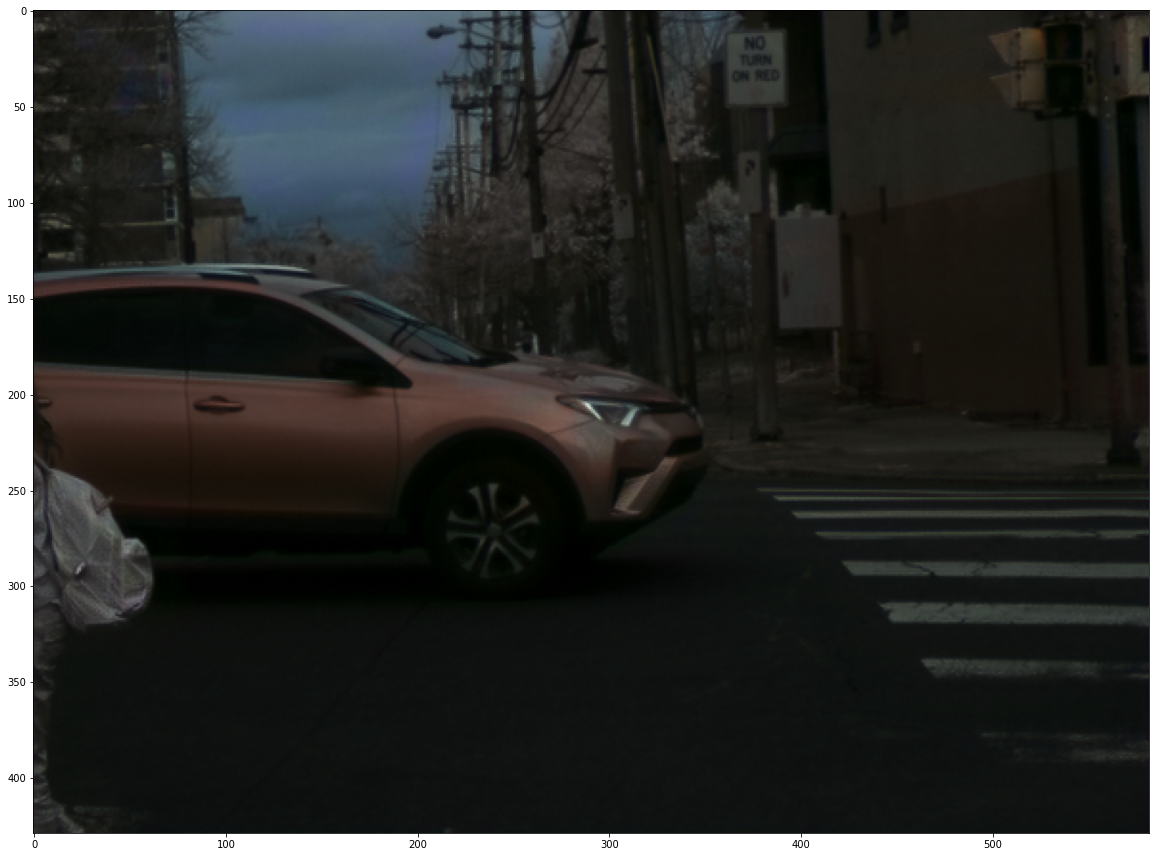

In [14]:
img = torch.clamp(out, 0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

In [15]:
cv2.imwrite(f'results/pittsburgh_{prefix}_asawhole_x4.png', img[..., ::-1]*255.0)

True